## Import standard libraries

In [8]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [9]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config, sdg

## Import training dataset

In [10]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge','train_data_transformed.csv'))

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'].to_numpy(dtype=np.int32)

# Get information summary on TS suitable for training
min_cdms = 5
print(f'Events suitable for training: {np.sum(nb_cdms>min_cdms)}'
      f' ({np.sum(nb_cdms>min_cdms)/len(nb_cdms)*100:.2f}%)')
print(f'TSs with event_id integrity for training: {np.sum(nb_cdms[nb_cdms>min_cdms]-min_cdms)}')

# Show first data points to explore data types
display(df[df['event_id'].isin([0,1,2])])

Events suitable for training: 9400 (71.46%)
TSs with event_id integrity for training: 104099


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,1.648115,0.706590,-9.879172,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.676499,0.499637,-6.567277,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,13.510814,38.329744,1.400673,5.586208,4.924475,10.903510,0.577410,3.841870,-1.914944,4.065123,-5.498756,-1.801545,-5.813629,-0.950721,89,83,42,11
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,1.607704,0.900255,-9.721584,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.676499,0.499637,-6.567277,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,11.645172,38.318093,1.260385,5.569076,4.026603,10.898258,0.588319,3.841512,-2.818890,4.059864,-5.585288,-1.805559,-5.831622,-0.950900,89,83,42,11
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,1.592208,0.695163,-9.712935,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15,15,100.0,2.360,NaN,0.676499,0.499637,-6.567277,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,10.757052,38.315920,1.212547,5.567071,3.624286,10.897246,0.599902,3.841445,-3.237592,4.058849,-5.633474,-1.805745,-5.820248,-0.950932,89,83,42,11
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,443,442,98.4,1.254,0.4020,1.6080

## Aritificial Neural Network model for Collision Risk Probability Estimation (CRPE)

#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [11]:
# Get input categorical and continuous features from config file.
con_features = list(config.get_features(**{'input':True, 'continuous':True}).keys())
cat_features = list(config.get_features(**{'input':True, 'continuous':False}).keys())

# Get output features
out_features = list(config.get_features(**{'input':False}).keys())

print(f'Output features:\n' + utils.tabular_list(out_features, n_cols=3, col_sep = ' - '))
print(f'Input Categorical features:\n' + utils.tabular_list(cat_features, n_cols=3, col_sep = ' - '))
print(f'Input Continuous features:\n' + utils.tabular_list(con_features, n_cols=3, col_sep = ' - '))

# Get Torch for all continuous features
conts = np.stack([df[f].to_numpy(dtype=str(df[f].dtype).lower()) for f in con_features], 1)
conts = torch.nan_to_num(torch.tensor(conts, dtype=torch.float))

# Get Torch for all categorical features
cats = np.stack([df[f].cat.codes.values for f in cat_features], 1)
cats = torch.tensor(cats, dtype=torch.int)

# Get Torch for output features
y = np.stack([df[f].to_numpy(dtype=str(df[f].dtype).lower()) for f in out_features], 1)
y = torch.tensor(y, dtype=torch.float) 

# This will set embedding sizes for the categorical columns:
# an embedding size is the length of the array into which every category
# is converted
cat_szs = [len(df[f].cat.categories) for f in cat_features]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

for f, feature in enumerate(cat_features):
    print(f'Feature {feature:20s} Embedding size: {emb_szs[f]} '
          f'(Unique vectors: {emb_szs[f][0]} | Length: {emb_szs[f][1]})')

Output features:
 - risk                 	 - max_risk..stimate    	

Input Categorical features:
 - t_time_la..ob_start    	 - c_object_type          	 - c_time_lastob_end      	
 - t_time_lastob_end      	 - c_time_la..ob_start    	

Input Continuous features:
 - time_to_tca                  	 - t_ctdot_rdot                 	 - c_cndot_n                    	
 - miss_distance                	 - t_cndot_r                    	 - c_cndot_rdot                 	
 - relative_speed               	 - t_cndot_t                    	 - c_cndot_tdot                 	
 - relative_position_r          	 - t_cndot_n                    	 - t_span                       	
 - relative_position_t          	 - t_cndot_rdot                 	 - c_span                       	
 - relative_position_n          	 - t_cndot_tdot                 	 - t_h_apo                      	
 - relative_velocity_r          	 - c_recommended_od_span        	 - t_h_per                      	
 - relative_velocity_t          	 - c_

In [12]:
print(conts.shape, conts[:1])
print(cats.shape, cats[:1])
print(y.shape, y[:1])

train_split = 0.75

batch_size = int(((len(df)*train_split)//1000)*1000)
test_size = len(df) - batch_size

print(f'Batch size: {batch_size} \t Test size: {test_size}')

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

torch.Size([162634, 93]) tensor([[ 1.5668e+00,  1.4923e+04,  1.3792e+04,  4.5380e+02,  5.9766e+03,
         -1.3667e+04, -7.2000e+00, -1.2637e+04, -5.5259e+03,  3.7800e+00,
          3.7800e+00,  4.5900e+02,  4.5800e+02,  9.8900e+01,  1.2650e+00,
          4.0200e-01,  1.6481e+00,  7.0659e-01, -9.8792e+00,  6.9969e+03,
          3.9966e-03,  9.7806e+01, -3.9797e-01,  2.9226e-01,  4.0799e-02,
          3.9422e-01, -9.9967e-01, -3.8498e-02, -9.8110e-01,  2.1461e-01,
         -3.1649e-01, -2.1025e-01,  1.7074e-01, -1.5509e-03,  5.3159e-01,
          2.1171e-03, -1.7928e-01,  1.5850e+01,  1.5850e+01,  1.5000e+01,
          1.5000e+01,  1.0000e+02,  2.3600e+00,  0.0000e+00,  6.7650e-01,
          4.9964e-01, -6.5673e+00,  7.0066e+03,  3.1437e-03,  7.4046e+01,
         -8.2486e-01,  4.7398e-01, -2.5757e-03,  8.2522e-01, -1.0000e+00,
          3.5654e-03, -7.3295e-01,  2.2001e-01, -8.1425e-01, -2.2062e-01,
          2.4986e-01,  1.9662e-01,  7.2219e-01, -1.9691e-01, -6.6849e-01,
          1.0

### Define loss function and optimizer

In [13]:
# Define Collision Risk Probability Estimator
class CRPE(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        
        # Inherit attributes from nn.Module class
        super().__init__()
        
        #############################################################################
        # Instanciate functions to use on the forward operation:
        
        # self.embeds: Creates a list of pre-configured Embedding operations (it is 
        # configured by passing the number of categories ni and the length of the 
        # embedding nf)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        
        # self.emb_drop: Cancels a proportion p of the embeddings.
        self.emb_drop = nn.Dropout(p)
        
        # self.bn_cont = Normalizes continuous features. This function is configured
        # by passing the number of continuous features to normalize.
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        #############################################################################
        # Count total number of embeddings (Total number of vector components for
        # every feature)
        n_emb = sum((nf for ni,nf in emb_szs))
        
        # Compute total number of inputs to pass to the initial layer (data point = 
        # Nb. of embeddings + Nb. of continuous variables)
        n_in = n_emb + n_cont
        
        # Run through every layer to set up the operations to perform per layer.
        # (i.e. layers=[100, 50, 200])
        layerlist = []
        for l, n_neurons in enumerate(layers):
            # On layer l, which contains n_neurons, perform the following operations:
            # 1. Apply Linear neural network model regression (fully connected network -> z = Sum(wi*xi+bi))
            layerlist.append(nn.Linear(n_in,n_neurons))
            
            # 2. Apply ReLU activation function (al(z))
            layerlist.append(nn.ReLU(inplace=True))
            
            # 3. Normalize data using the n_neurons
            layerlist.append(nn.BatchNorm1d(n_neurons))
            
            # 4. Cancel out a random proportion p of the neurons to avoid overfitting
            layerlist.append(nn.Dropout(p))
            
            # 5. Set new number of input features n_in for the next layer l+1.
            n_in = n_neurons
        
        # Set the last layer of the list which corresponds to the final output
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Instantiate layers as a Neural Network sequential task
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Initialize embeddings list
        embeddings = []
        
        # Apply embedding function e from self.embeds to the category i
        # in x_cat array
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        # Concatenate embedding sections into 1
        x = torch.cat(embeddings, 1)
        
        # Apply dropout function to to the embeddings torch
        x = self.emb_drop(x)
        
        # Normalize continuous variables
        x_cont = self.bn_cont(x_cont)
        
        # Concatenate embeddings with continuous variables into one torch
        x = torch.cat([x, x_cont], 1)
        
        # Process all data points with the layers functions (sequential of operations)
        x = self.layers(x)
        
        return x

In [14]:
torch.manual_seed(33)

layers = [200, 400, 300, 100]
n_out = len(out_features)
n_conts = conts.shape[1]

# Instanciate the model with the input parameters
model = CRPE(emb_szs, n_conts, n_out, layers, p=0.4)

# Print the model
model

# Define loss function (criterion) and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

## Train the model

In [15]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i%25 == 0 or i==0:
        print(f'Epoch: {i:3}  Loss: {loss.item():10.8f}')
        # print(y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(f'\nFinal loss: {loss.item():10.8f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Epoch:  25  Loss: 215.78184509
Epoch:  50  Loss: 193.94430542
Epoch:  75  Loss: 154.48591614
Epoch: 100  Loss: 100.60919952
Epoch: 125  Loss: 55.78467941
Epoch: 150  Loss: 27.45672607
Epoch: 175  Loss: 14.25680351
Epoch: 200  Loss: 10.08778191
Epoch: 225  Loss: 8.82088661
Epoch: 250  Loss: 7.89249325
Epoch: 275  Loss: 7.22388697
Epoch: 300  Loss: 6.74303293
Epoch: 325  Loss: 6.28647852
Epoch: 350  Loss: 5.98015547
Epoch: 375  Loss: 5.68990660
Epoch: 400  Loss: 5.40623188
Epoch: 425  Loss: 5.23861456
Epoch: 450  Loss: 4.99343777
Epoch: 475  Loss: 4.89482212
Epoch: 500  Loss: 4.74808502

Final loss: 4.74808502

Duration: 313 seconds


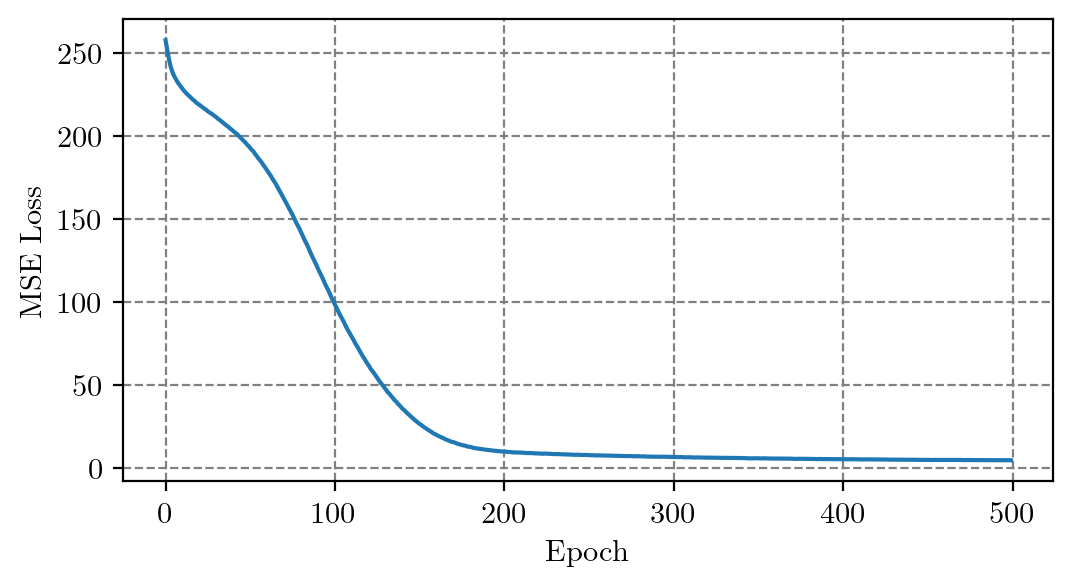

In [16]:
plt.figure(figsize=(6,3))
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.grid(True, linestyle='--', c='grey')
plt.show()

In [17]:
# Evaluate entire dataset
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'MSE Loss: {loss:.8f}')

MSE Loss: 9.47496605


In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score as accuracy

# Define risk threshold for collision avoidance manouvre.
risk_threshold = -4.0

# Get outputs from the model from the entire dataset.
output = []
for i in range(len(y_test)):
    y_pred = y_val[i][0].item()
    y_true = y_test[i][0].item()
    diff = np.abs(y_pred-y_true)

    output.append([y_pred, y_true, diff, y_pred>=risk_threshold, y_true>=risk_threshold])
    

# Create DataFrame with the results and print the first rows
df_val = pd.DataFrame(data=output, columns=['pred_risk','true_risk', 'delta', 'pred_avoidance_flag', 'true_avoidance_flag'])
display(df_val.head(10))

# Evaluate accuracy using the confusion matrix.
y_true = df_val['true_avoidance_flag']
y_pred = df_val['pred_avoidance_flag']

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print(f'Model accuracy = {accuracy(y_true, y_pred)*100:5.2f}%\n')
print(f'TP: {tp:^6} FP: {fp:^6}\n'
      f'FN: {fn:^6} TN: {tn:^6}')

,pred_risk,true_risk,delta,pred_avoidance_flag,true_avoidance_flag
0,-9.027144,-6.487716,2.539429,False,False
1,-6.129854,-6.482144,0.352291,False,False
2,-7.328360,-7.380907,0.052547,False,False
3,-9.620742,-7.682982,1.937760,False,False
4,-4.300293,-7.447697,3.147404,False,False
5,-4.823674,-6.079929,1.256255,False,False
6,-4.594398,-6.293880,1.699482,False,False
7,-5.602274,-6.815025,1.212750,False,False
8,-6.120299,-6.652670,0.532371,False,False
9,-7.217945,-6.750313,0.467632,False,False


Model accuracy = 98.59%

TP:   25   FP:  427  
FN:  158   TN: 41024 



## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html